In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [3]:
if os.path.exists('dog3.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog_full.jpg

dog.jpg exists


In [4]:
img = torchvision.io.read_image("dog3.jpg")
img

tensor([[[ 91,  90,  88,  ...,  63,  67,  50],
         [186, 186, 186,  ..., 134, 135, 119],
         [192, 190, 190,  ..., 138, 141, 124],
         ...,
         [190, 183, 183,  ..., 144, 143, 127],
         [196, 188, 187,  ..., 146, 141, 127],
         [197, 191, 190,  ..., 145, 142, 122]],

        [[ 75,  76,  76,  ...,  59,  63,  49],
         [171, 171, 173,  ..., 129, 131, 115],
         [175, 175, 175,  ..., 132, 135, 119],
         ...,
         [183, 176, 176,  ...,  71,  72,  60],
         [190, 180, 180,  ...,  73,  72,  59],
         [191, 185, 182,  ...,  74,  75,  59]],

        [[ 50,  50,  50,  ...,  30,  36,  21],
         [138, 138, 139,  ...,  99, 102,  86],
         [132, 132, 132,  ...,  98, 103,  87],
         ...,
         [105,  98,  98,  ...,  26,  30,  18],
         [114, 105, 102,  ...,  28,  30,  20],
         [115, 109, 107,  ...,  28,  32,  18]]], dtype=torch.uint8)

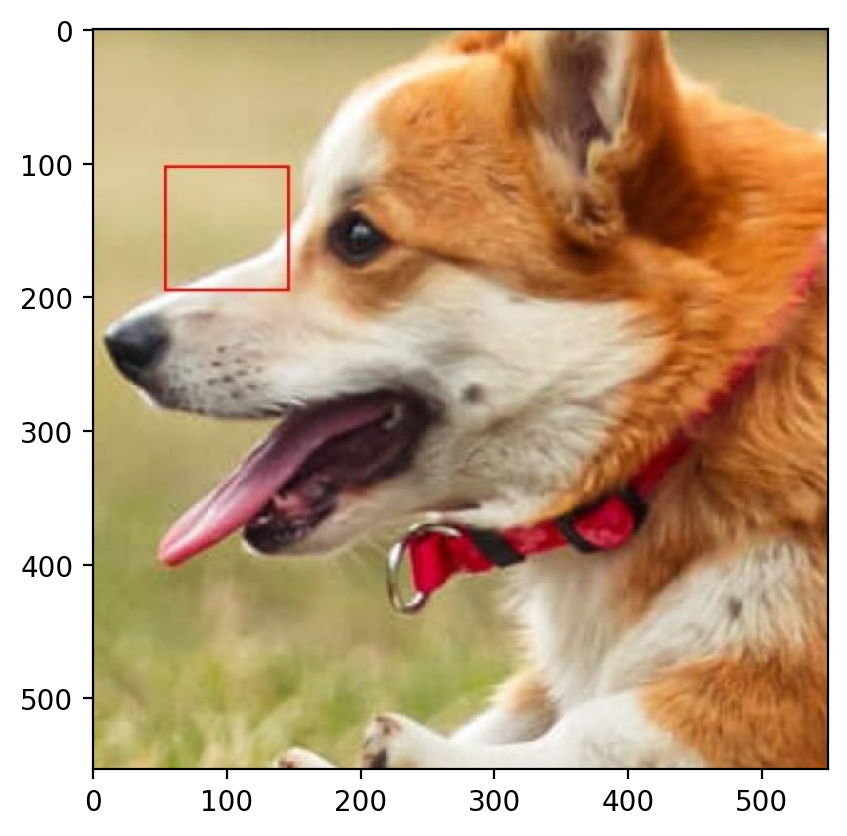

In [5]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [6]:
# Import the preprocessing module from the scikit-learn library
from sklearn import preprocessing

# Reshape the image array into a 2D array where each pixel value becomes a row. 
# 'img.reshape(-1, 1)' flattens the image (which might be 2D or 3D for RGB images) 
# into a single column, with each pixel or pixel channel being a separate row.
# This step is necessary because the MinMaxScaler works with 2D data (samples x features).

# Apply Min-Max scaling to the image. The fit() method computes the minimum and maximum 
# values for scaling the image data to a range of [0, 1] (by default).
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))

# 'scaler_img' is now a fitted MinMaxScaler object that stores the min and max values 
# from the image and can be used to transform the image data accordingly.
scaler_img

# Scale the image data using the fitted scaler.
# First, we reshape the image to a 2D array of shape (total_pixels, 1) to match the input format
# that the MinMaxScaler expects. We then apply the transform() function, which scales the image data 
# to the [0, 1] range, based on the min and max values learned during fitting.
# Finally, we reshape the scaled data back to the original image shape for further processing.
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)

# Display the shape of the scaled image to confirm it matches the original image dimensions.
# This ensures that the reshaping after scaling preserved the original structure of the image.
img_scaled.shape

# Convert the scaled image (which is a NumPy array) into a PyTorch tensor.
# This is often necessary when working with deep learning frameworks like PyTorch,
# as most neural network models expect inputs in the form of tensors.
img_scaled = torch.tensor(img_scaled)
# Move the scaled image tensor to a specific device (e.g., GPU or CPU).
# This is particularly important when working with deep learning models in PyTorch,
# as computations can be performed on different devices. By moving the tensor to the 'device',
# the scaled image can now be processed on the specified hardware (e.g., CUDA-enabled GPU or CPU).
img_scaled = img_scaled.to(device)

# Display the scaled image tensor. This step helps verify that the tensor has been moved to the correct device
# and that it retains the expected structure and data after the device transfer.
img_scaled


tensor([[[0.3569, 0.3529, 0.3451,  ..., 0.2471, 0.2627, 0.1961],
         [0.7294, 0.7294, 0.7294,  ..., 0.5255, 0.5294, 0.4667],
         [0.7529, 0.7451, 0.7451,  ..., 0.5412, 0.5529, 0.4863],
         ...,
         [0.7451, 0.7176, 0.7176,  ..., 0.5647, 0.5608, 0.4980],
         [0.7686, 0.7373, 0.7333,  ..., 0.5725, 0.5529, 0.4980],
         [0.7725, 0.7490, 0.7451,  ..., 0.5686, 0.5569, 0.4784]],

        [[0.2941, 0.2980, 0.2980,  ..., 0.2314, 0.2471, 0.1922],
         [0.6706, 0.6706, 0.6784,  ..., 0.5059, 0.5137, 0.4510],
         [0.6863, 0.6863, 0.6863,  ..., 0.5176, 0.5294, 0.4667],
         ...,
         [0.7176, 0.6902, 0.6902,  ..., 0.2784, 0.2824, 0.2353],
         [0.7451, 0.7059, 0.7059,  ..., 0.2863, 0.2824, 0.2314],
         [0.7490, 0.7255, 0.7137,  ..., 0.2902, 0.2941, 0.2314]],

        [[0.1961, 0.1961, 0.1961,  ..., 0.1176, 0.1412, 0.0824],
         [0.5412, 0.5412, 0.5451,  ..., 0.3882, 0.4000, 0.3373],
         [0.5176, 0.5176, 0.5176,  ..., 0.3843, 0.4039, 0.

In [7]:
# Crop the scaled image tensor using PyTorch's torchvision library.
# The 'torchvision.transforms.functional.crop()' function extracts a region of the image defined by
# the starting coordinates (top, left) and the height and width of the desired crop.
# In this case, we crop a 50x50 patch from the image starting at the (top=150, left=250) position.
# We first move the image tensor back to the CPU using .cpu() before applying the cropping operation,
# as torchvision's transformations are typically applied on CPU tensors.
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 150, 250, 50, 50)

# Display the shape of the cropped image tensor to confirm the dimensions.
# Since we are cropping a 50x50 patch, the output shape should reflect this size, 
# along with any additional channels (e.g., RGB channels) if present in the original image.
crop.shape


torch.Size([3, 50, 50])


Testing with r = 5
Iteration 0, Loss: 125.54961218917225
Iteration 100, Loss: 36.600156838588184
Iteration 200, Loss: 3.161655946884891
Iteration 300, Loss: 2.874980687966052
Iteration 400, Loss: 2.257158603281616
Iteration 500, Loss: 1.7567807559603341
Iteration 600, Loss: 1.5741823464166427
Iteration 700, Loss: 1.4182510376700068
Iteration 800, Loss: 1.2353130043259608
Iteration 900, Loss: 1.083834174546512
Channel 0 - Final Loss: 0.9636257652977753
Iteration 0, Loss: 108.9928791316516
Iteration 100, Loss: 25.898702744589183
Iteration 200, Loss: 3.0103823167698627
Iteration 300, Loss: 1.592098516083257
Iteration 400, Loss: 1.0984610134152655
Iteration 500, Loss: 0.9915577053356536
Iteration 600, Loss: 0.9701777395342294
Iteration 700, Loss: 0.957067294179
Iteration 800, Loss: 0.9429378985556691
Iteration 900, Loss: 0.9239959644943257
Channel 1 - Final Loss: 0.9020951373814947
Iteration 0, Loss: 117.26656006774256
Iteration 100, Loss: 22.59151298413645
Iteration 200, Loss: 2.88172720

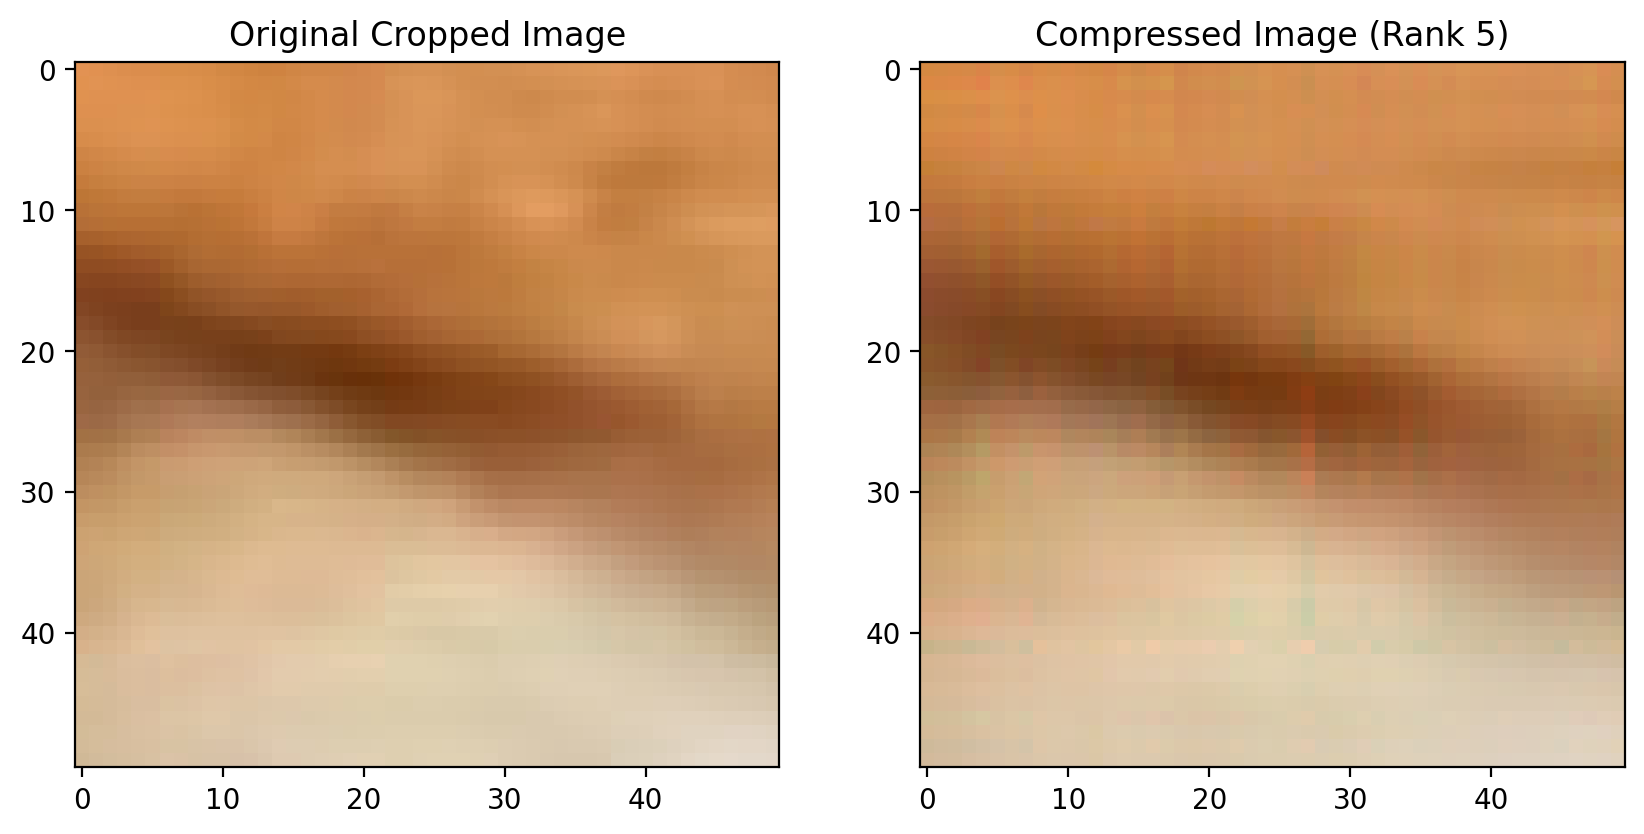


Testing with r = 10
Iteration 0, Loss: 162.70031270506158
Iteration 100, Loss: 25.13539780978981
Iteration 200, Loss: 2.7152610038595992
Iteration 300, Loss: 1.6166385832442203
Iteration 400, Loss: 1.0047905472466094
Iteration 500, Loss: 0.8450920498020448
Iteration 600, Loss: 0.7899784251950471
Iteration 700, Loss: 0.753161078117582
Iteration 800, Loss: 0.7123268998996455
Iteration 900, Loss: 0.6733451250458533
Channel 0 - Final Loss: 0.6451271509650391
Iteration 0, Loss: 160.68207317867527
Iteration 100, Loss: 20.82764762398914
Iteration 200, Loss: 2.578721374528106
Iteration 300, Loss: 1.5033381582045813
Iteration 400, Loss: 1.1881618301949057
Iteration 500, Loss: 1.0282500509544388
Iteration 600, Loss: 0.9525997614292433
Iteration 700, Loss: 0.9006253951881782
Iteration 800, Loss: 0.8397000303913963
Iteration 900, Loss: 0.7536192463641049
Channel 1 - Final Loss: 0.6740874052334609
Iteration 0, Loss: 164.16434039876455
Iteration 100, Loss: 22.126122961804363
Iteration 200, Loss: 2.

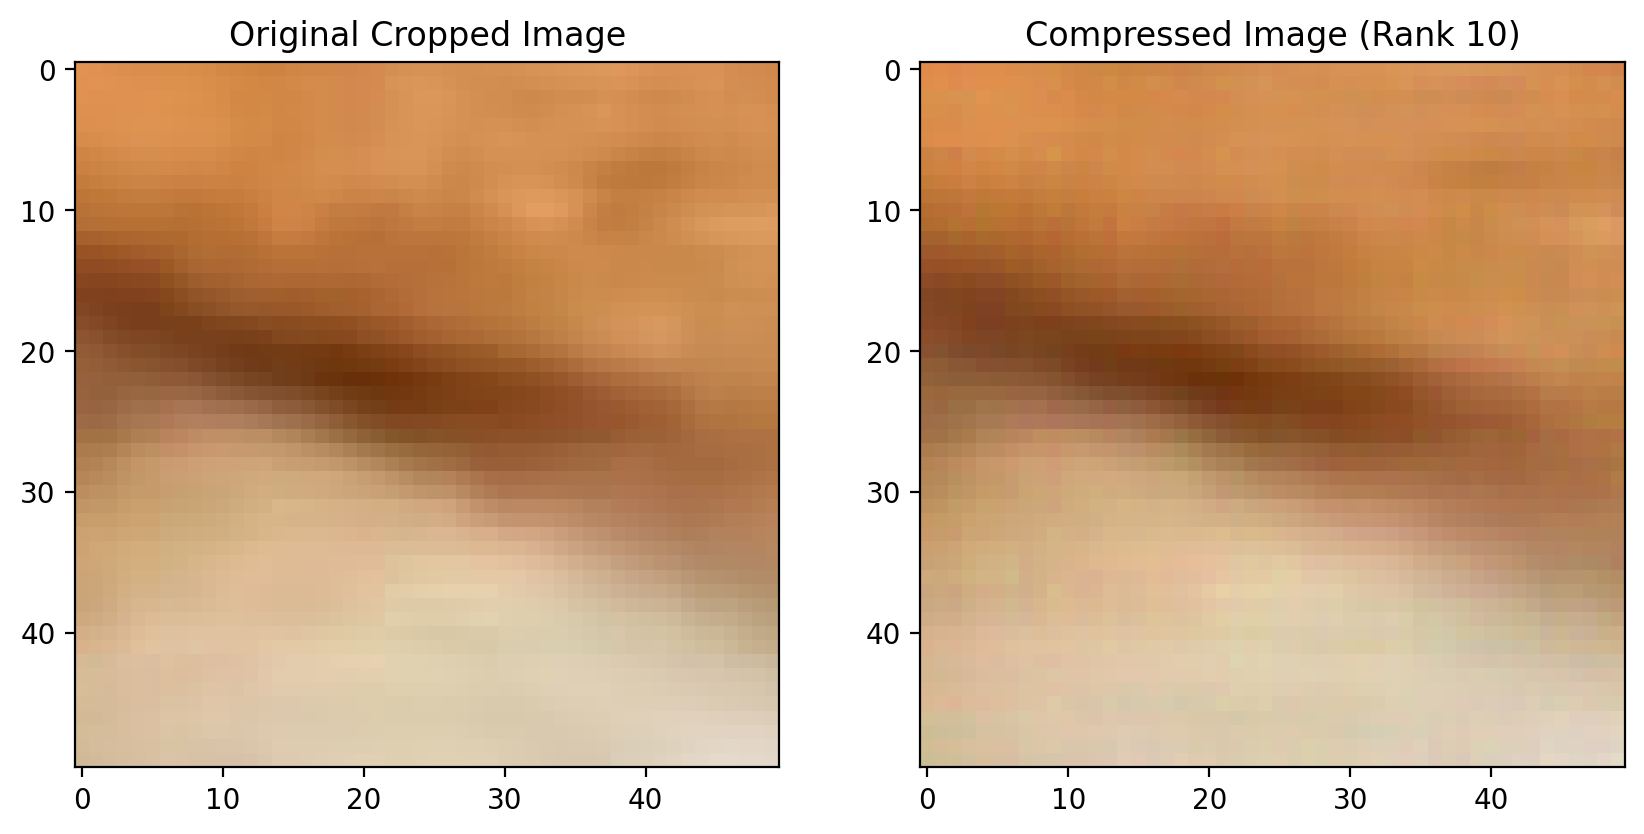


Testing with r = 25
Iteration 0, Loss: 243.27431100216495
Iteration 100, Loss: 7.09796744382688
Iteration 200, Loss: 1.0558834576147906
Iteration 300, Loss: 0.812827325978264
Iteration 400, Loss: 0.7142870074345768
Iteration 500, Loss: 0.645749931986986
Iteration 600, Loss: 0.5782219271097968
Iteration 700, Loss: 0.5205804246318931
Iteration 800, Loss: 0.49143473804878507
Iteration 900, Loss: 0.4684850708612668
Channel 0 - Final Loss: 0.45207297730834767
Iteration 0, Loss: 238.87709505560474
Iteration 100, Loss: 7.4179823900135196
Iteration 200, Loss: 1.029123742959382
Iteration 300, Loss: 0.7689770111920247
Iteration 400, Loss: 0.6715989328357869
Iteration 500, Loss: 0.597882164149195
Iteration 600, Loss: 0.5655575476207215
Iteration 700, Loss: 0.5102787396364394
Iteration 800, Loss: 0.4854390475109735
Iteration 900, Loss: 0.46233008332082004
Channel 1 - Final Loss: 0.4421937457322731
Iteration 0, Loss: 255.45532205538908
Iteration 100, Loss: 9.920335806549287
Iteration 200, Loss: 1.

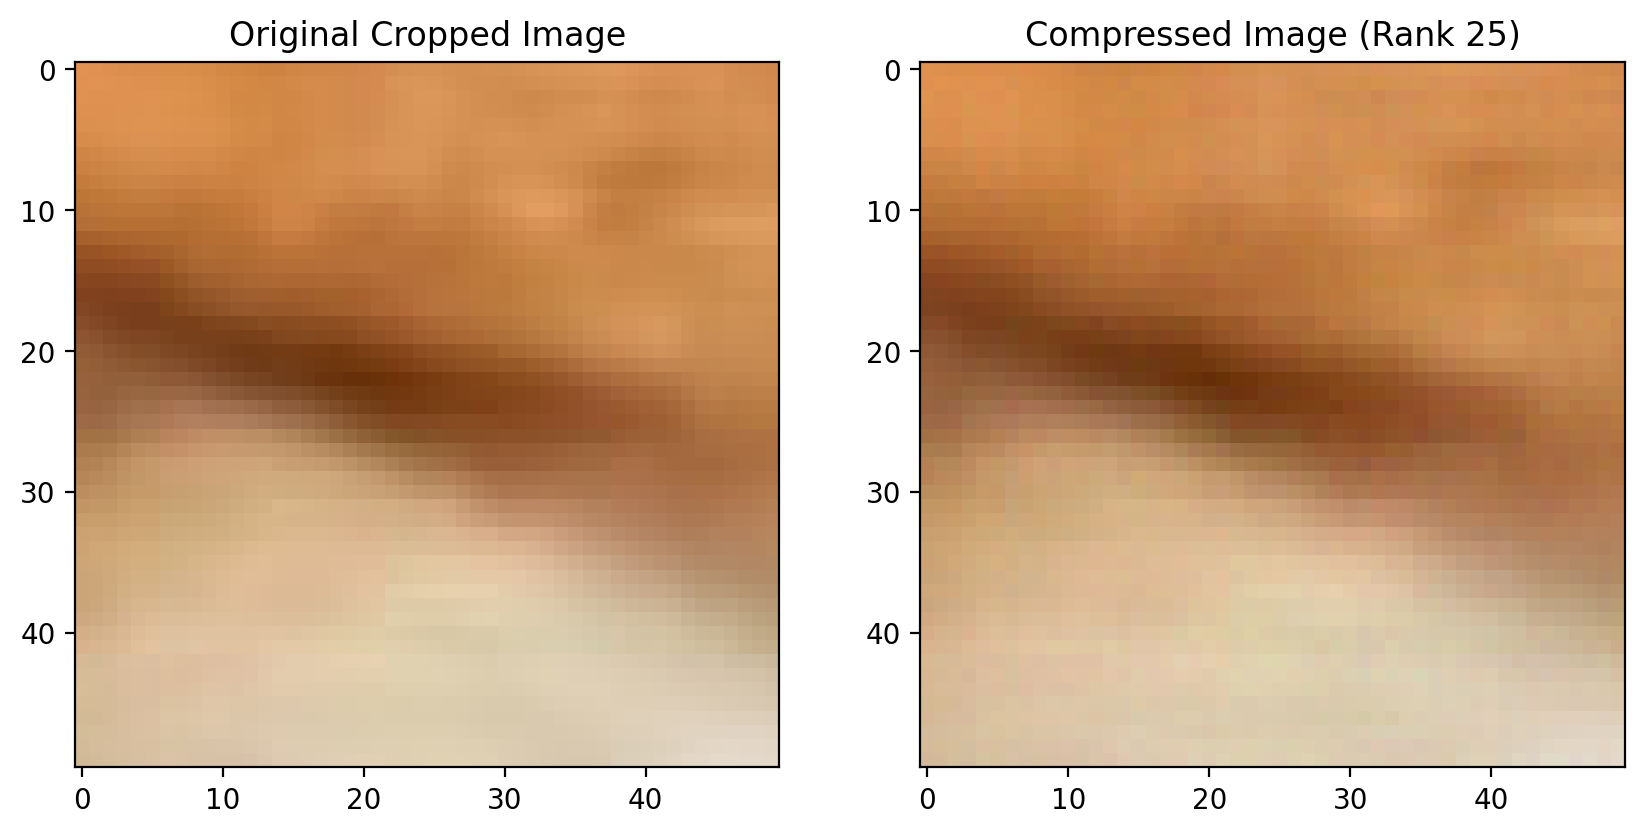


Testing with r = 50
Iteration 0, Loss: 352.6380974944434
Iteration 100, Loss: 3.0125792086327623
Iteration 200, Loss: 0.7233487322805036
Iteration 300, Loss: 0.5151002104549549
Iteration 400, Loss: 0.45988108666011024
Iteration 500, Loss: 0.4316802022638326
Iteration 600, Loss: 0.40843149252194194
Iteration 700, Loss: 0.4040341074375879
Iteration 800, Loss: 0.3893755243357047
Iteration 900, Loss: 0.3828984264990821
Channel 0 - Final Loss: 0.37640670179052393
Iteration 0, Loss: 350.33763672575907
Iteration 100, Loss: 3.053461278521874
Iteration 200, Loss: 0.608351236284924
Iteration 300, Loss: 0.49924204960197105
Iteration 400, Loss: 0.4517357979861566
Iteration 500, Loss: 0.4373041047939922
Iteration 600, Loss: 0.41093129116211874
Iteration 700, Loss: 0.4070402701306739
Iteration 800, Loss: 0.3942282728649085
Iteration 900, Loss: 0.38612417331292614
Channel 1 - Final Loss: 0.3734852534493037
Iteration 0, Loss: 340.79277059282884
Iteration 100, Loss: 2.843658988483503
Iteration 200, Lo

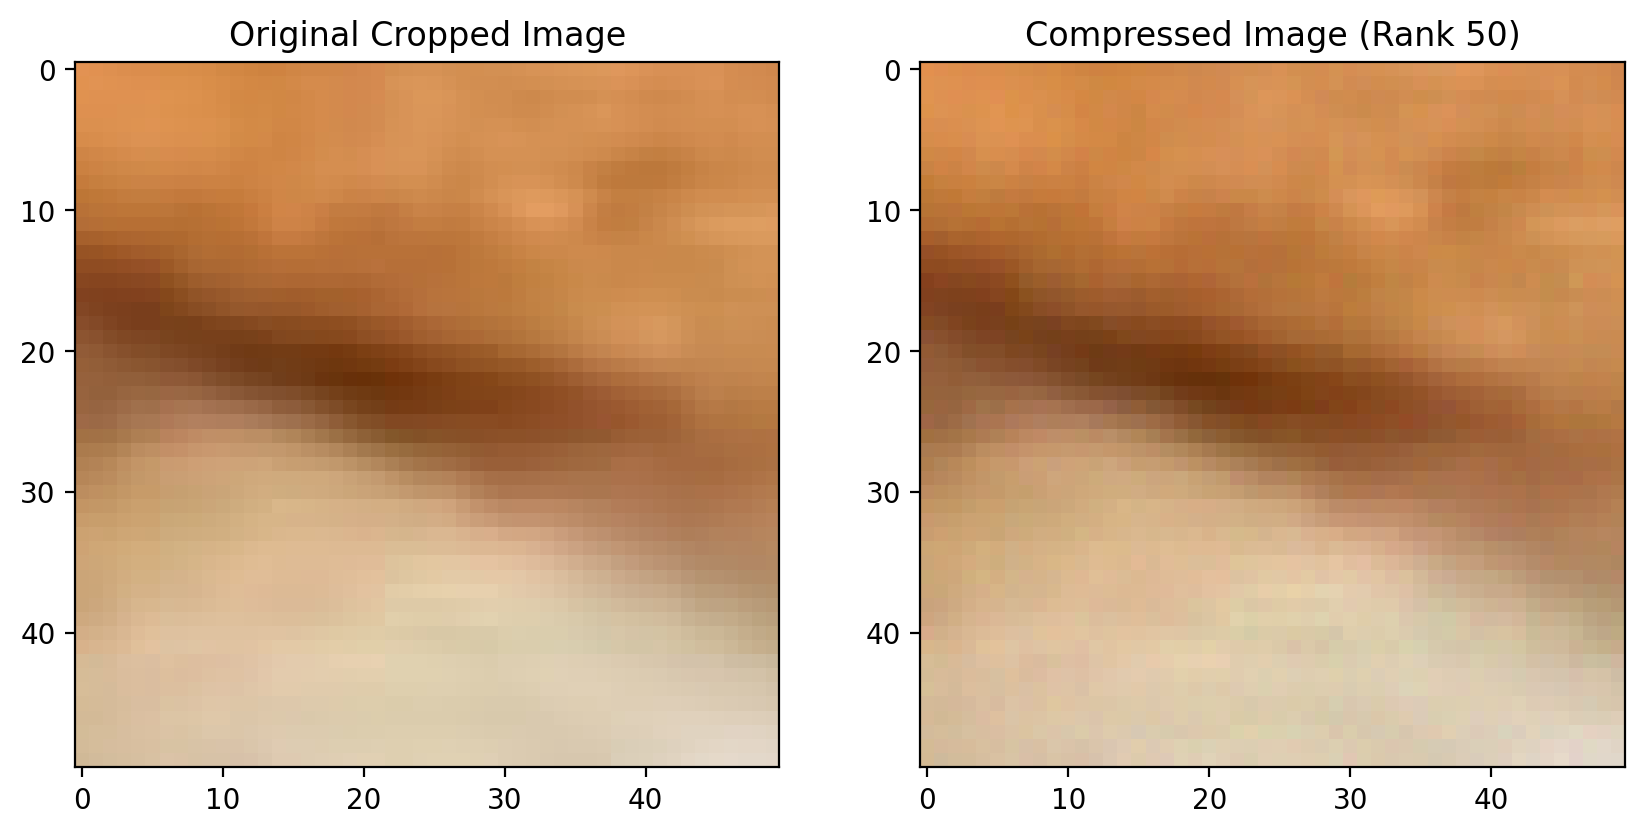

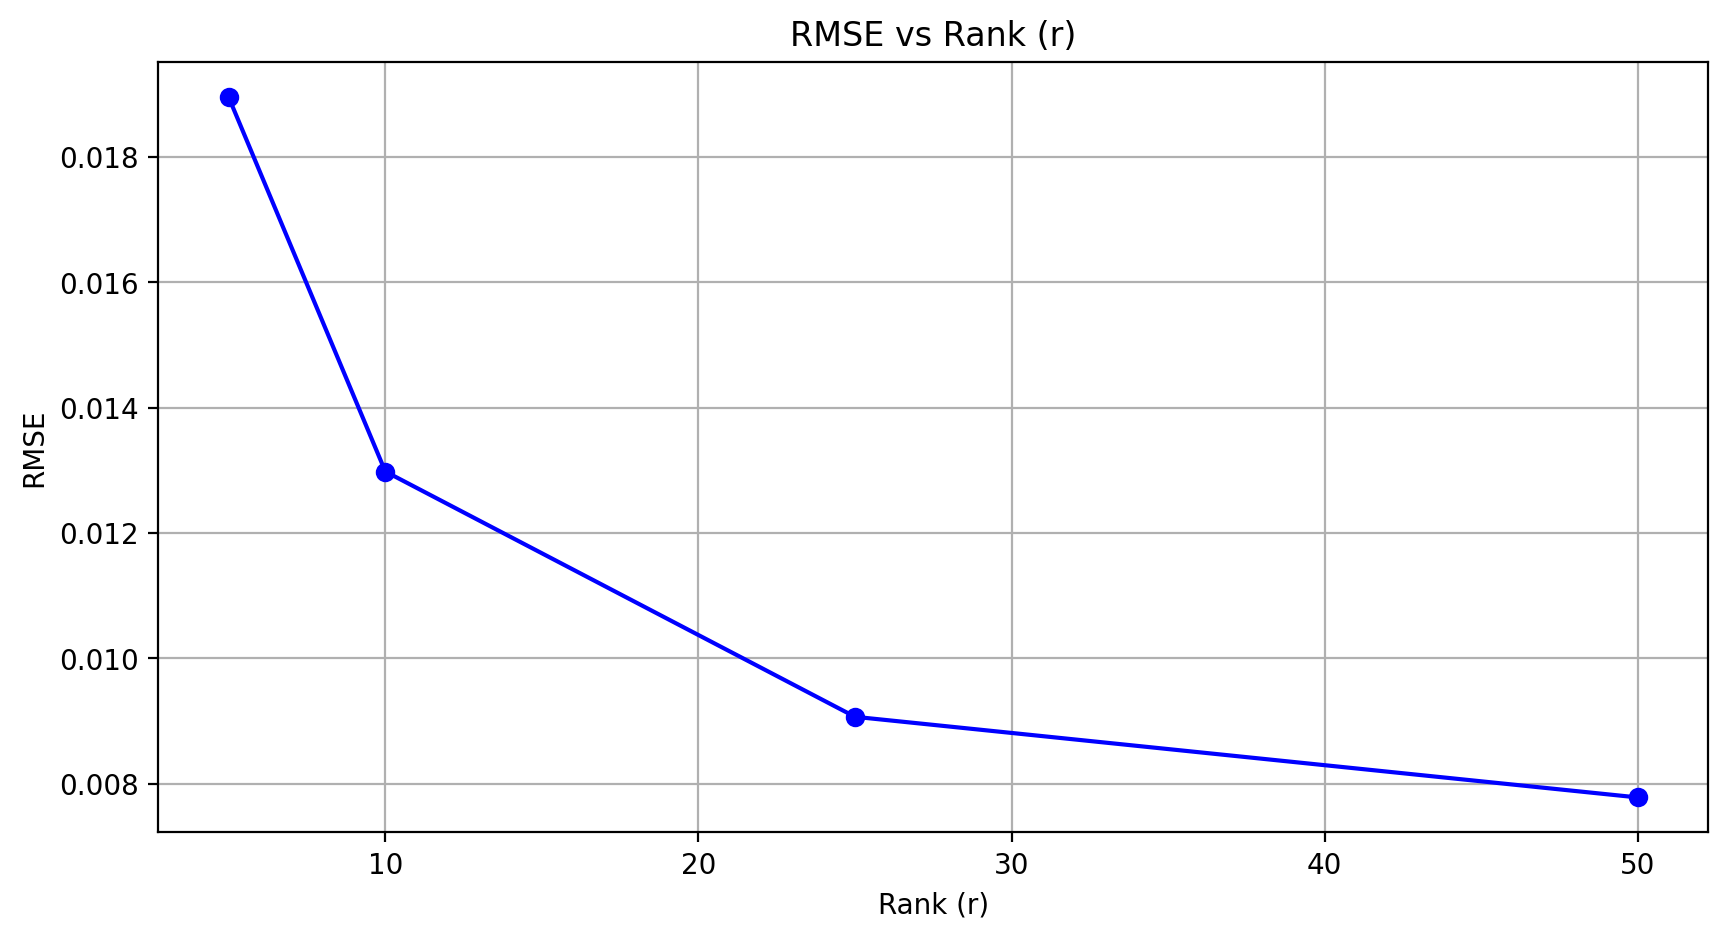

Text(0, 0.5, 'PSNR ')

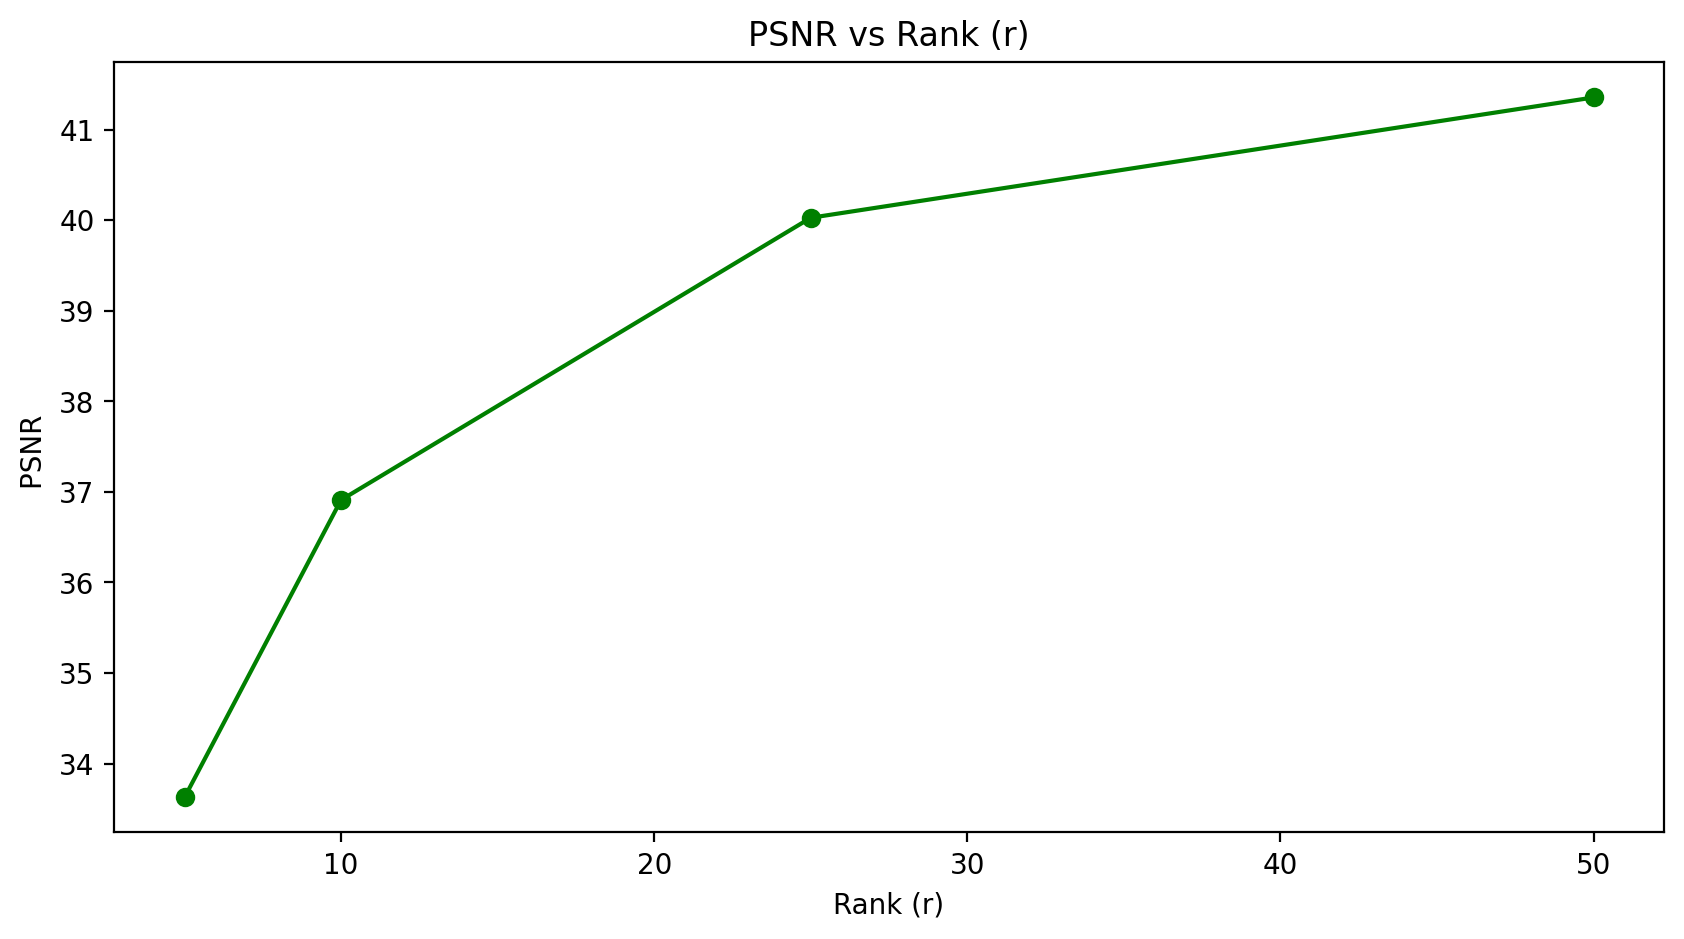

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange

# Function to compute RMSE
def compute_rmse(original, reconstructed):
    return torch.sqrt(torch.mean((original - reconstructed) ** 2)).item()

# Function to compute PSNR
def compute_psnr(original, reconstructed):
    mse = torch.mean((original - reconstructed) ** 2).item()
    if mse == 0:
        return float('inf')
    max_pixel = torch.max(original).item()
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(torch.tensor(mse)))
    return psnr.item()

# Perform factorization for each channel (R, G, B)
def factorize(A, k, device=torch.device("cpu")):
    """Factorize the matrix A into W and H where A ≈ W * H"""
    A = A.to(device)
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    optimizer = torch.optim.Adam([W, H], lr=0.01)
    for i in range(1000):
        diff_matrix = torch.mm(W, H) - A
        loss = torch.norm(diff_matrix)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")
    return W, H, loss

# Lists to store RMSE and PSNR values for each value of r
rmse_values = []
psnr_values = []

# Values for r to test
r_values = [5, 10, 25, 50]

for r in r_values:
    print(f"\nTesting with r = {r}")
    reconstructed_channels = []
    for channel in range(3):  
        crop_matrix = crop[channel].view(50, 50)
        W, H, loss = factorize(crop_matrix, r, device=device)
        print(f"Channel {channel} - Final Loss: {loss.item()}")
        reconstructed_matrix = torch.mm(W, H).cpu().detach()
        reconstructed_channels.append(reconstructed_matrix)
    reconstructed_image = torch.stack(reconstructed_channels).unsqueeze(0)

    reconstructed_full_image = crop.clone()
    reconstructed_full_image[:, :, :] = reconstructed_image  

    rmse = compute_rmse(crop, reconstructed_full_image.squeeze())
    psnr = compute_psnr(crop, reconstructed_full_image.squeeze())

    print(f"RMSE: {rmse}")
    print(f"PSNR: {psnr}")

    rmse_values.append(rmse)
    psnr_values.append(psnr)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(rearrange(crop.cpu().numpy(), 'c h w -> h w c'))
    axs[0].set_title('Original Cropped Image')
    axs[1].imshow(rearrange(reconstructed_image.squeeze().cpu().numpy(), 'c h w -> h w c'))
    axs[1].set_title(f'Compressed Image (Rank {r})')
    plt.show()

# Plot RMSE vs. r
plt.figure(figsize=(10, 5))
plt.plot(r_values, rmse_values, marker='o', linestyle='-', color='b')
plt.title('RMSE vs Rank (r)')
plt.xlabel('Rank (r)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

# Plot PSNR vs. r
plt.figure(figsize=(10, 5))
plt.plot(r_values, psnr_values, marker='o', linestyle='-', color='g')
plt.title('PSNR vs Rank (r)')
plt.xlabel('Rank (r)')
plt.ylabel('PSNR ')
